In [1]:
!nvidia-smi

Fri Sep 22 04:33:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%%capture
!pip install torchmetrics mlxtend torchinfo

# Import Libraries

In [3]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchinfo import summary

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

import random
import pandas as pd
from pathlib import Path
from tqdm.auto import trange,tqdm
import matplotlib.pyplot as plt
from timeit import default_timer as timer

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# FashionMNIST Dataset
> Dataset : https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html

### Download Dataset   
- Download train and test sets.
- Apply transformations to image data.

In [4]:
train_data = datasets.FashionMNIST(root='data',
                                  train=True,
                                  transform=ToTensor(),
                                  download=True)
test_data = datasets.FashionMNIST(root='data', 
                                train=False,
                                transform=ToTensor(),
                                download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 8828759.51it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 134969.55it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2668005.41it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9038207.20it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [5]:
len(train_data), len(test_data)

(60000, 10000)

### Dataset Classes
- FashionMNIST dataset has 10 classes of apparel.

In [6]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### Dataset Classes with Indices

In [7]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

### Sample Image Shape and Label

In [8]:
img, label = train_data[0]
img.shape, label

(torch.Size([1, 28, 28]), 9)

# Data Visualization

(-0.5, 27.5, 27.5, -0.5)

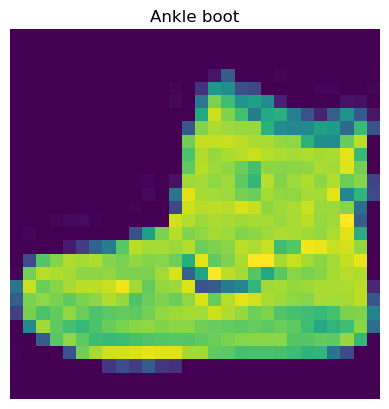

In [9]:
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis('off')

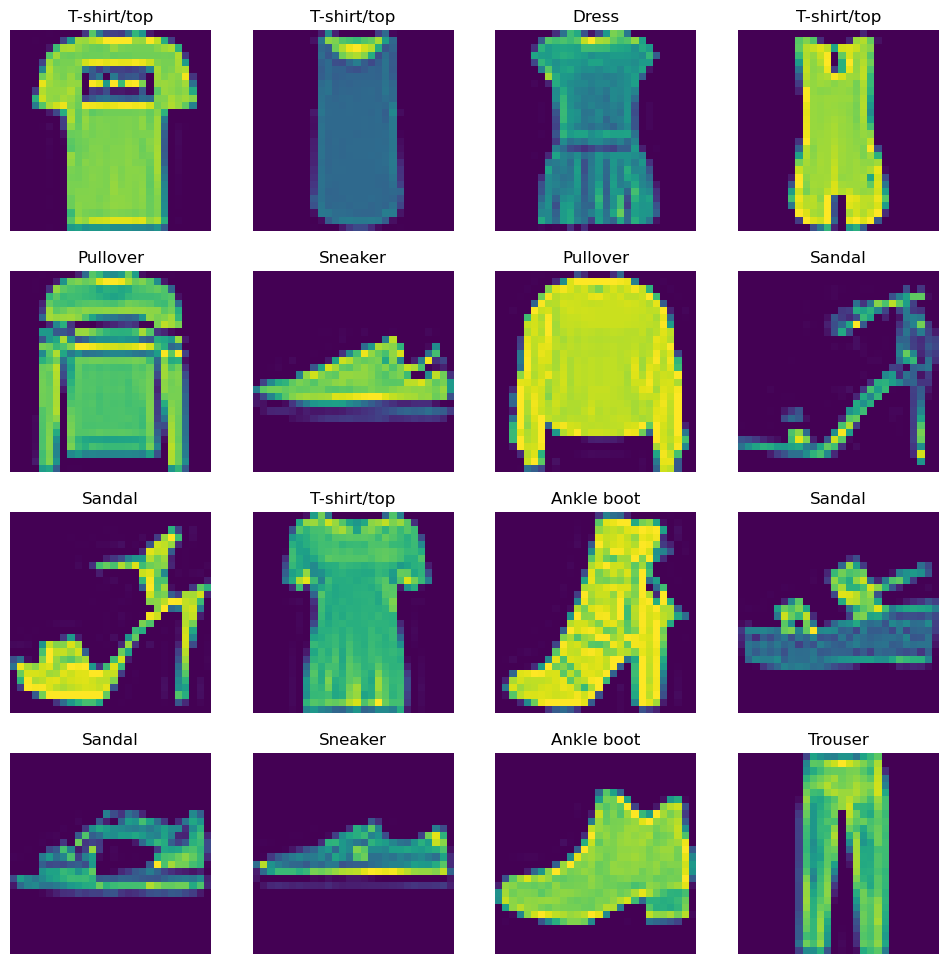

In [10]:
fig = plt.figure(figsize=(12, 12))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    img, label = train_data[i]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1,2,0))
    plt.title(class_names[label])
    plt.axis("off")

# Data Preparation

In [11]:
BATCH_SIZE = 32

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(test_loader)

(1875, 313)

In [12]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image shape: torch.Size([1, 28, 28])
Label: Sandal


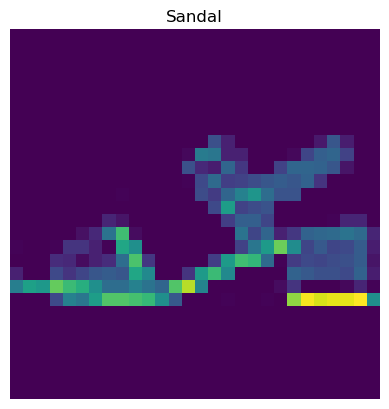

In [13]:
rand_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis("off")
print(f"Image shape: {img.shape}")
print(f"Label: {class_names[label]}")

# VGG16 Model Architecture
> Architecture as per https://blog.paperspace.com/vgg-from-scratch-pytorch/

In [14]:
class VGG16(nn.Module):
    """
        Implementation of VGG16 architecture.
        
        Args:
            num_classes (int): Specify number of classes for multi-class classification task.
            
        Returns:
            Training loss, Training accuracy, Testing loss, Testing accuracy, Total training time.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [15]:
vgg16 = VGG16(num_classes=100)
summary(vgg16, input_size=(32,3,224,224),col_names=['input_size','output_size','num_params','trainable'],col_width=25)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
VGG16                                    [32, 3, 224, 224]         [32, 100]                 --                        True
├─Sequential: 1-1                        [32, 3, 224, 224]         [32, 64, 224, 224]        --                        True
│    └─Conv2d: 2-1                       [32, 3, 224, 224]         [32, 64, 224, 224]        1,792                     True
│    └─BatchNorm2d: 2-2                  [32, 64, 224, 224]        [32, 64, 224, 224]        128                       True
│    └─ReLU: 2-3                         [32, 64, 224, 224]        [32, 64, 224, 224]        --                        --
├─Sequential: 1-2                        [32, 64, 224, 224]        [32, 64, 112, 112]        --                        True
│    └─Conv2d: 2-4                       [32, 64, 224, 224]        [32, 64, 224, 224]        36,928                    True
│    

# tinyVGG Architecture
#### Since the original VGG16 model is very expensive to train, both in terms of time and compute, we will experiment on a smaller model of the same architecture.
> Architecture as per: https://poloclub.github.io/cnn-explainer/

In [16]:
class tinyVGG(nn.Module):
    """Implementation of tinyVGG model.
        
        Args:
            input_shape - Input tensor shape.
            hidden_units - Number of units for the intermediate convolution layers.
            output_shape - Output tensor shape.
    """    
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [17]:
tinyvgg = tinyVGG(input_shape=1,
                 hidden_units=32,
                 output_shape=len(class_names))
summary(tinyvgg, input_size=(32,1,28,28),col_names=['input_size','output_size','num_params','trainable'],col_width=25)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
tinyVGG                                  [32, 1, 28, 28]           [32, 10]                  --                        True
├─Sequential: 1-1                        [32, 1, 28, 28]           [32, 32, 14, 14]          --                        True
│    └─Conv2d: 2-1                       [32, 1, 28, 28]           [32, 32, 28, 28]          320                       True
│    └─ReLU: 2-2                         [32, 32, 28, 28]          [32, 32, 28, 28]          --                        --
│    └─Conv2d: 2-3                       [32, 32, 28, 28]          [32, 32, 28, 28]          9,248                     True
│    └─BatchNorm2d: 2-4                  [32, 32, 28, 28]          [32, 32, 28, 28]          64                        True
│    └─ReLU: 2-5                         [32, 32, 28, 28]          [32, 32, 28, 28]          --                        --
│    └─

# Model Training

### Model Train Time Function

In [18]:
def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time

### Model Accuracy Function

In [19]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### Train and Test Step Functions

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [21]:
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device):
    """Performs a single step of training.
    
        Args:
            model: PyTorch model to train.
            data_loader: DataLoader object to load train/ test image data.
            loss_fn: Loss function to train model on.
            optimizer: Optimizer to update model weights and biases.
            accuracy_fn: Calculates model accuracy, either train/test.
            device: Device (CPU/GPU/TPU)
            
        Returns:
            Training loss, Training accuracy.
    """
    # Initialize training loss and accuracy
    train_loss, train_acc = 0, 0
    
    # Set model to 'train' mode.
    model.train()
    
    # Iterate through DataLoader
    for batch, (X, y) in enumerate(data_loader):
        
        # Send data to device
        X, y = X.to(device), y.to(device)
        
        # Get predictions from model
        y_pred = model(X)
        
        # Compute model loss and accuracy
        loss = loss_fn(y_pred, y)
        acc = accuracy_fn(y, y_pred.argmax(dim=1))
        
        # Accumulate training loss and accuracy
        train_loss += loss
        train_acc += acc
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Compute average training loss and accuracy
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    print(f'Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}')

In [22]:
def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device):
    """Performs a single step of testing.
    
        Args:
            model: PyTorch model to test.
            data_loader: DataLoader object to load train/ test image data.
            loss_fn: Loss function to test model on.
            accuracy_fn: Calculates model accuracy, either train/test.
            device: Device (CPU/GPU/TPU)
            
        Returns:
            Testing loss, Testing accuracy.
    """
    # Initialize testing loss and accuracy
    test_loss, test_acc = 0, 0
    
    # Set model to 'evaluation' mode
    model.eval()
    
    # Using torch.inference_mode() to ensure zero gradients, compute testing loss and accuracy
    with torch.inference_mode():
        # Iterate through DataLoader
        for batch, (X, y) in enumerate(data_loader):
            
            # Send data to device
            X, y = X.to(device), y.to(device)
            
            # Get predictions from model
            y_pred = model(X)
            
            # Compute model loss and accuracy
            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y, y_pred.argmax(dim=1))
            
            # Accumulate testing loss and accuracy
            test_loss += loss
            test_acc += acc
            
        # Compute average testing loss and accuracy
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
    print(f'Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}')

### Train Model Function

In [23]:
def train_model(
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    epochs: int = 10,
    device: torch.device = device):
    """Trains a model for specified number of epochs.
        
        Args:
            model: PyTorch model to train.
            train_loader: DataLoader object to load training image data.
            test_loader: DataLoader object to load testing image data.
            loss_fn: Loss function to train model on.
            optimizer: Optimizer to update model weights and biases.
            accuracy_fn: Calculates model accuracy, either train/test.
            epochs: Number of epochs to train model for.
            device: Device (CPU/GPU/TPU)
            
        Returns: 
            Training loss, Training accuracy, Testing loss, Testing accuracy, Total Training time.
    """
    train_time_start = timer()
    for epoch in trange(epochs):
        print(f'Epoch: {epoch} \n -----------------------')
        
        train_step(model, train_loader, loss_fn, optimizer, accuracy_fn, device)
        test_step(model, test_loader, loss_fn, accuracy_fn, device)
    
    train_time_end = timer()
    print_train_time(train_time_start, train_time_end, device=device)

### Training tinyVGG Model
> Karpathy constant: https://twitter.com/karpathy/status/801621764144971776

In [24]:
epochs = 7
learning_rate = 3e-4  # Karpathy constant
num_classes = 100

model = tinyVGG(input_shape=1,
               hidden_units=32,
               output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
train_model(model,
           train_loader,
           test_loader,
           loss_fn,
           optimizer,
           accuracy_fn,
           epochs,
           device)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 0 
 -----------------------
Train loss: 0.3888 | Train accuracy: 86.0867
Test loss: 0.3209 | Test accuracy: 88.1190
Epoch: 1 
 -----------------------
Train loss: 0.2611 | Train accuracy: 90.5717
Test loss: 0.2720 | Test accuracy: 90.4054
Epoch: 2 
 -----------------------
Train loss: 0.2236 | Train accuracy: 91.8717
Test loss: 0.2495 | Test accuracy: 90.9145
Epoch: 3 
 -----------------------
Train loss: 0.1987 | Train accuracy: 92.8850
Test loss: 0.2307 | Test accuracy: 91.7732
Epoch: 4 
 -----------------------
Train loss: 0.1806 | Train accuracy: 93.4317
Test loss: 0.2326 | Test accuracy: 91.7931
Epoch: 5 
 -----------------------
Train loss: 0.1662 | Train accuracy: 94.1267
Test loss: 0.2346 | Test accuracy: 91.9529
Epoch: 6 
 -----------------------
Train loss: 0.1515 | Train accuracy: 94.5967
Test loss: 0.2383 | Test accuracy: 91.8031

Train time on cuda: 90.966 seconds


# tinyVGG Evaluation
- Evaluating model
- Making predictions
- Plotting Confusion Matrix

### Model Evaluation Function

In [26]:
def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device=device):
    """Returns a dictionary containing the results of model predictions on data_loader.
       
       Args:
           model: PyTorch model to evaluate.
           data_loader: DataLoader object to load testing images.
           loss_fn: Loss function to test model on.
           accuracy_fn: Calculates model accuracy, either train/test.
           device: Device (CPU/GPU/TPU)
    """
    # Initialize loss and accuracy 
    loss, acc = 0, 0
    
    # Set model to 'evaluate' mode
    model.eval()
    
    # Compute loss and accuracy with torch.inference_mode() to ensure zero gradients
    with torch.inference_mode():
        # Iterate through data_loader
        for X, y in tqdm(data_loader):
            # Send data to device
            X, y = X.to(device), y.to(device)
            
            # Computer model predictions
            y_pred = model(X)
            
            # Compute and accumulate loss and accuracy
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))
            
        # Compute average loss and accuracy
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {
        'Model name' : model.__class__.__name__,
        'Model loss' : loss.item(),
        'Model accuracy' : acc
    }

In [27]:
tinyVGG_results = eval_model(model, test_loader, loss_fn, accuracy_fn)
tinyVGG_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'Model name': 'tinyVGG',
 'Model loss': 0.23826374113559723,
 'Model accuracy': 91.80311501597444}

### Model Predictions Function

In [28]:
def make_predictions(
    model: torch.nn.Module,
    data: list,
    device: torch.device=device):
    
    """Returns model's prediction probability tensor.
        
       Args:
           model: PyTorch model to make predictions.
           data: Data on which model will make predictions.
           device: Device (CPU/GPU/TPU)
    """
    # Initialize prediction probability list
    pred_probs = []
    
    # Set model to 'evaluate' mode
    model.eval()
    
    # Compute model prediction probabilities in torch.inference_mode() to ensure zero gradients
    with torch.inference_mode():
        # Iterate through data to generate predictions
        for sample in data:
            
            # Reshaping data and sending it to device
            sample = torch.unsqueeze(sample, dim=0).to(device)
            
            # Compute prediction logit from model
            pred_logit = model(sample)
            
            # Compute prediction probability from prediction logit by apply softmax function
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            
            # Extending list of prediction probabilities
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

### Compute Model Prediction Probabilities

In [29]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)
    
pred_probs = make_predictions(model, test_samples)
pred_classes = pred_probs.argmax(dim=1)
pred_probs, pred_classes

(tensor([[7.8359e-05, 9.9989e-01, 1.0324e-06, 2.5080e-05, 3.0956e-06, 2.5169e-08,
          3.9605e-07, 9.2657e-09, 8.8480e-07, 5.4226e-08],
         [9.5474e-04, 9.9885e-01, 2.8898e-06, 1.9003e-04, 2.0834e-06, 7.5226e-09,
          4.5220e-06, 5.3463e-09, 1.9010e-07, 1.8198e-08],
         [8.4306e-01, 1.9838e-07, 7.9229e-02, 4.2066e-03, 3.1173e-03, 1.2754e-09,
          7.0389e-02, 4.9961e-08, 8.6222e-07, 4.2653e-09],
         [9.8003e-01, 3.0532e-10, 1.0170e-05, 2.3687e-04, 8.4687e-08, 4.8100e-09,
          1.9718e-02, 4.3857e-09, 1.1574e-07, 8.6439e-12],
         [9.9913e-01, 2.8747e-08, 2.4306e-05, 1.5179e-05, 1.8632e-05, 1.0887e-10,
          8.1133e-04, 1.1031e-09, 3.1090e-06, 1.2017e-12],
         [8.7978e-09, 2.1385e-15, 2.6524e-11, 2.1440e-11, 9.3721e-12, 1.0000e+00,
          6.5664e-11, 2.1646e-11, 2.2727e-08, 1.5901e-07],
         [4.1620e-03, 4.8144e-07, 6.3256e-01, 9.1591e-05, 3.2069e-01, 4.8999e-08,
          4.2487e-02, 1.4599e-07, 1.2835e-05, 6.7146e-07],
         [2.1

### Visualizing Results

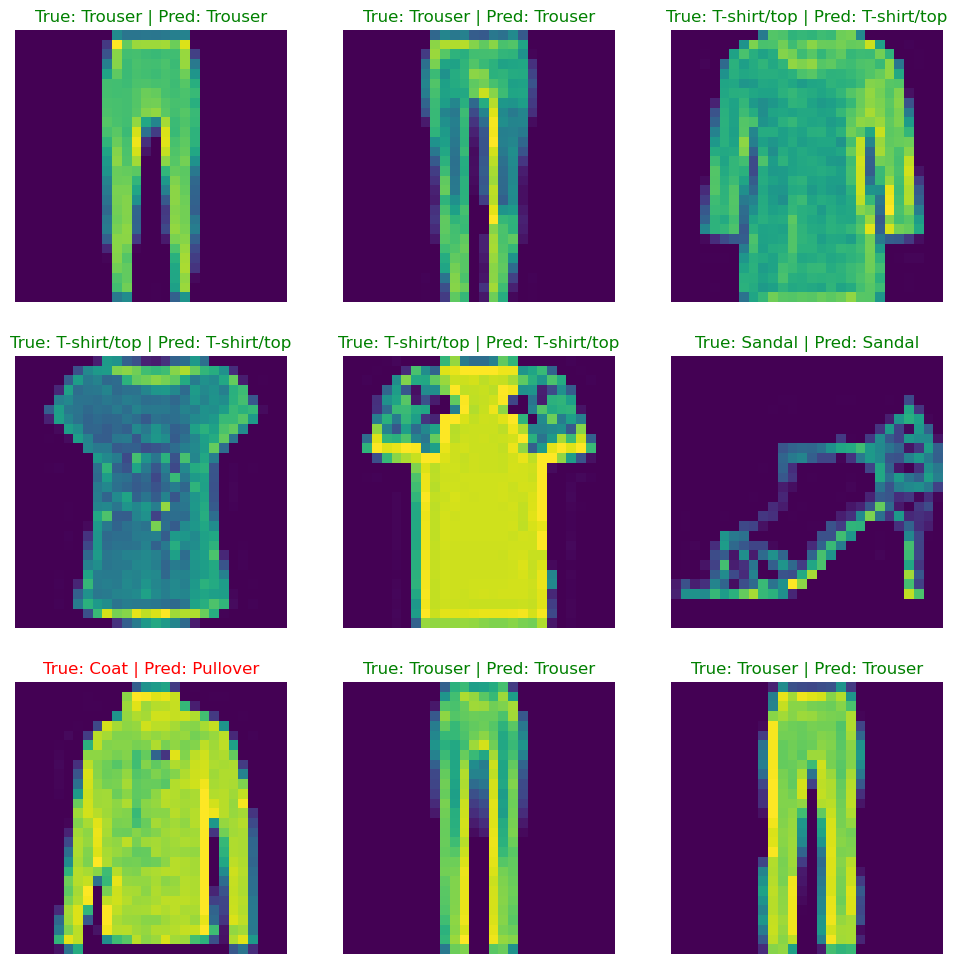

In [30]:
plt.figure(figsize=(12,12))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze())
    title_txt = f"True: {class_names[test_labels[i]]} | Pred: {class_names[pred_classes[i]]}"
    plt.axis("off")
    if class_names[pred_classes[i]] == class_names[test_labels[i]]:
        plt.title(title_txt,c='g')
    else:
        plt.title(title_txt,c='r')

### Confusion Matrix

In [31]:
y_preds = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_loader, 'Making predictions...'):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        
        y_preds.append(y_pred.cpu())
        
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 0])

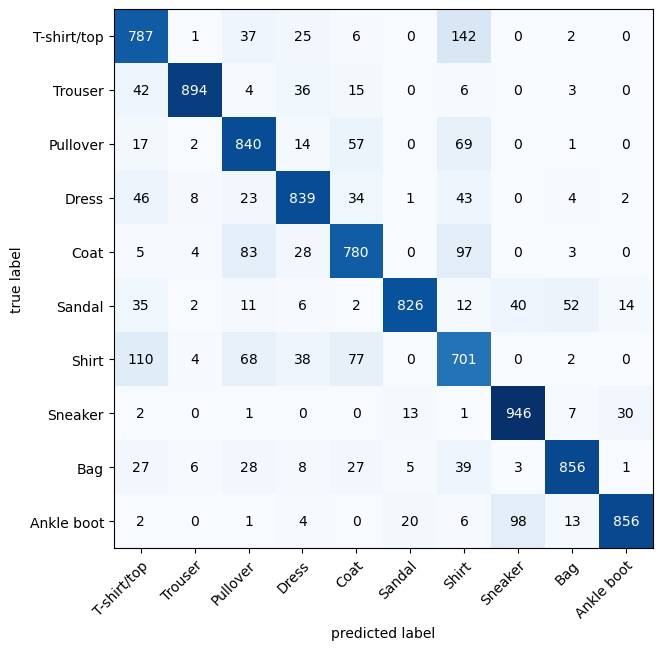

In [32]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task='multiclass',num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(),
                                class_names=class_names,
                                figsize=(10,7))

# Saving Model

In [33]:
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEL_NAME = 'tinyVGG_fashionMNIST.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(model.state_dict(), MODEL_SAVE_PATH)

Saving model to: models/tinyVGG_fashionMNIST.pth
